In [ ]:
!pip install pgmpy

In [ ]:
import nltk
nltk.download("brown")
nltk.download("treebank")
nltk.download("conll2000")
nltk.download("universal_tagset")
from nltk.corpus import brown, treebank, conll2000

brown_sentences = brown.tagged_sents(tagset="universal")
treebank_sentences = treebank.tagged_sents(tagset="universal")
conll_sentences = conll2000.tagged_sents(tagset="universal")

brown_tags = sorted(set(tag for sentence in brown_sentences for _, tag in sentence))
treebank_tags = sorted(set(tag for sentence in treebank_sentences for _, tag in sentence))
conll_tags = sorted(set(tag for sentence in conll_sentences for _, tag in sentence))
print("Brown sentences:", len(brown_sentences))
print("Treebank sentences:", len(treebank_sentences))
print("Conll2000 sentences:", len(conll_sentences))
print("Brown Tags:", len(brown_tags))
print("Treebank Tags:", len(treebank_tags))
print("Conll2000 Tags:", len(conll_tags))

tags = sorted(set(brown_tags + treebank_tags + conll_tags))
print("All tags:", len(tags))
print(tags)

In [ ]:
from sklearn.model_selection import train_test_split
test_sentences = [
    [("The", "DET"), ("cat", "NOUN"), ("plays", "VERB")],
    [("The", "DET"), ("dog", "NOUN"), ("plays", "VERB")],
    [("The", "DET"), ("pretty", "ADJ"), ("dog", "NOUN"), ("plays", "VERB")],
    [("The", "DET"), ("pretty", "ADJ"), ("cat", "NOUN"), ("plays", "VERB")],
    [("I", "NOUN"), ("play", "VERB"), ("with", "PRT"), ("a", "DET"), ("cat", "NOUN")],
]

working_sentences, test_sentences = train_test_split(list(brown_sentences), train_size=0.7, random_state=100)
# working_sentences = test_sentences

In [ ]:
from pandas import DataFrame


def get_features(word):
  hyphen = '-' in word
  uppercase = word[0].isupper()
  return {
      "hyphen": hyphen,
      "uppercase": uppercase
  }

def get_features_tuples(word):
  features = get_features(word)
  return sorted(features.items())

sentence_info = [(sentence_id, word_index, word, pos_tag, *[val for _,val in get_features_tuples(word)]) # Feature vector
                    for sentence_id, sentence in enumerate(working_sentences) 
                      for word_index, (word, pos_tag) in enumerate(sentence)]

df = DataFrame(data=sentence_info, columns=[
    "sentence_id",
    "word_index",
    "word",
    "pos_tag",
    *[name for name, _ in get_features_tuples("random word")]
])
print(df.head())

def get_bigram_df(df, max=-1):
  """
  Returns a new DataFrame with a single row containing the columns names suffixed with 0 or 1
  representing the position on the bigram. 
  """
  rows = iter(df.iterrows())
  columns = [c for c in df.columns]
  result_columns = [f"{x}_{i}" for x in columns for i in range(2)]
  to_return = { key:[] for key in result_columns }
  _,previous = next(rows)
  count = 0
  for _,row in rows:
    if max != -1 and count >= max:
      return DataFrame(to_return)
    for col_name,value in zip(columns,previous):
      to_return[col_name+"_0"].append(value)
    for col_name,value in zip(columns,row):
      to_return[col_name+"_1"].append(value)
    previous = row
    count+=1
  return DataFrame(to_return)

bigram_df = get_bigram_df(df)

print(bigram_df.head())


   sentence_id  word_index    word pos_tag  hyphen  uppercase
0            0           0      ``       .   False      False
1            0           1      To     PRT   False       True
2            0           2      Be    VERB   False       True
3            0           3    Left    VERB   False       True
4            0           4  Behind     ADV   False       True
   sentence_id_0  sentence_id_1  word_index_0  word_index_1  word_0  word_1  \
0              0              0             0             1      ``      To   
1              0              0             1             2      To      Be   
2              0              0             2             3      Be    Left   
3              0              0             3             4    Left  Behind   
4              0              0             4             5  Behind      ''   

  pos_tag_0 pos_tag_1  hyphen_0  hyphen_1  uppercase_0  uppercase_1  
0         .       PRT     False     False        False         True  
1       PRT  

In [ ]:
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.models import BayesianNetwork as BN
from pgmpy.inference import DBNInference
from pgmpy.estimators import ParameterEstimator, MaximumLikelihoodEstimator, BayesianEstimator
import numpy as np

verbose = False

hidden = {
    "pos_tag", # Part-Of-Speech tag
}

hidden_posible_values = {
    "pos_tag": tags
}

hidden_card = {
    "pos_tag": len(hidden_posible_values["pos_tag"]), # Part-Of-Speech tag
}

observable = { 
    "uppercase", # If the wrd is capitalized
    "hyphen", # If the word has an -
}

observable_posible_values = {
    "uppercase": [False, True],
    "hyphen": [False, True],
}

observable_card = {
    "uppercase": len(observable_posible_values["uppercase"]),
    "hyphen": len(observable_posible_values["hyphen"]),
}

dbnet = DBN()
# Connect all hidden variables to observable variables
dbnet.add_edges_from([((x, 0), (y, 0)) for x in hidden for y in observable])
# Add 1-1 hidden states connections between slices
dbnet.add_edges_from([((x, 0), (x, 1)) for x in hidden])
# All cpds
cpds = []


# Get Initial estimator

# Initial CPD Info, only sees the initial word of sentences
df_init = df[df["word_index"] == 0]

# Creating initial Bayesian network
init_bayes = BN()
# Connect all hidden variables to observable variables
init_bayes.add_edges_from([(x, y) for x in hidden for y in observable])

# Estimating CPD for Initial Network
cpd = MaximumLikelihoodEstimator(init_bayes, df_init)
initial_cpd_pos = cpd.estimate_cpd('pos_tag')

# Adding number correspondence to tags
number_2_pos_dict = initial_cpd_pos.no_to_name['pos_tag']
missing_tags = {len(number_2_pos_dict)+i:tag for i, tag in enumerate(set(tags).difference(number_2_pos_dict.values()))}
number_2_pos_dict.update(missing_tags)

# Fixing missing POS tags in Initial CPD by adding the remaining tags with 0 probability
initial_cpd_values = initial_cpd_pos.get_values()
pos_probabilities = np.reshape(np.array([x for x in initial_cpd_values] + [x for x in np.zeros(len(tags) - initial_cpd_values.shape[0])]), (len(tags),1))

# Initial CPD
start_cpd = TabularCPD(
    variable=("pos_tag",0),
    variable_card=len(tags),
    values=pos_probabilities,
    evidence=[], 
    evidence_card=[], 
    state_names={("pos_tag",0):[number_2_pos_dict[i] for i in range(len(number_2_pos_dict))]}
  )
if verbose: print("Initial distribution")
if verbose: print(start_cpd)

# Adding CPD to Final CPDs list
cpds.append(start_cpd)

# Get 2-TBN estimator

two_tbn_bayes = BN()
# Connect all hidden variables to observable variables
two_tbn_bayes.add_edges_from([(f'{x}_0', f'{y}_0') for x in hidden for y in observable])
# Add 1-1 hidden states connections between slices
two_tbn_bayes.add_edges_from([(f'{x}_0', f'{x}_1') for x in hidden])

cpd = MaximumLikelihoodEstimator(two_tbn_bayes, bigram_df)

# Get transitions CPD for Hidden Variables
for hid in hidden:
  two_tbn_cpd = cpd.estimate_cpd(hid + "_1")
  # print(two_tbn_cpd)
  hid_cardinality = hidden_card[hid]
  two_tbn_cpd_no_to_name = two_tbn_cpd.no_to_name
  state_names = {
          (var[:-2], 0 if var[-1] == "0" else 1):[two_tbn_cpd_no_to_name[var][i] for i in range(len(two_tbn_cpd_no_to_name[var]))] 
              for var in two_tbn_cpd_no_to_name
  }

  # Values not in Dataset
  missing_values = set(hidden_posible_values[hid]).difference(state_names[hid,1])

  # Get value matrix
  values = two_tbn_cpd.get_values()
  for key in state_names:
    # Adding missing value names to state names
    state_names[key] += [missing for missing in missing_values]

  # Filling missing values with 0
  values = np.append(values, np.zeros((len(missing_values), values.shape[1])), axis=0)
  # Filling missing values with uniform distribution
  values = np.append(values, np.full((values.shape[0], len(missing_values)), 1/hidden_card[hid]), axis=1)

  two_tbn_cpd = TabularCPD(
      variable=(hid,1),
      variable_card=hid_cardinality,
      values=values, 
      evidence=[(hid,0)], 
      evidence_card=[hid_cardinality], 
      state_names=state_names
    )
  if verbose: print(f"Hidden state transition {hid}")
  if verbose: print(two_tbn_cpd)
  cpds.append(two_tbn_cpd)

# Get CPD for in-slice Variables
for observed in observable:
  two_tbn_cpd = cpd.estimate_cpd(observed + "_0")
  observed_cardinality = observable_card[observed]
  
  two_tbn_cpd_no_to_name = two_tbn_cpd.no_to_name
  state_names = {
          (var[:-2], 0 if var[-1] == "0" else 1):[two_tbn_cpd_no_to_name[var][i] for i in range(len(two_tbn_cpd_no_to_name[var]))] 
              for var in two_tbn_cpd_no_to_name
  }

  values = two_tbn_cpd.get_values()
  
  # Values not in Dataset
  missing_values = {
      (name,0): set((observable_posible_values if name in observable_posible_values else hidden_posible_values)[name])
            .difference(state_names[name,0]) for name,time in state_names 
  }
  
  # Get value matrix
  values = two_tbn_cpd.get_values()
  for key in state_names:
    # Adding missing value names to state names
    state_names[key] += [missing for missing in missing_values[key]]
  
  # Filling missing values with 0
  values = np.append(values, np.zeros((len(missing_values[observed,0]), values.shape[1])), axis=0)
  
  hidden_amount = 1
  for amount in hidden_card.values():
    hidden_amount *= amount

  # Filling missing hidden combinations with uniform distribution
  values = np.append(values, np.full((values.shape[0], hidden_amount - values.shape[1]), 1/observable_card[observed]), axis=1)

  two_tbn_cpd = TabularCPD(
      variable=(observed,0),
      variable_card= observed_cardinality,
      values=values,
      evidence=[(hid,0) for hid in hidden], 
      evidence_card=[hidden_card[hid] for hid in hidden], 
      state_names=state_names
    )
  if verbose: print(f"Observable variable {observed}")
  if verbose: print(two_tbn_cpd)
  cpds.append(two_tbn_cpd)


dbnet.add_cpds(*cpds)
dbnet.initialize_initial_state()

# pe = ParameterEstimator(dbnet, df[["pos_tag", "uppercase", "word", "hyphen"]])


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


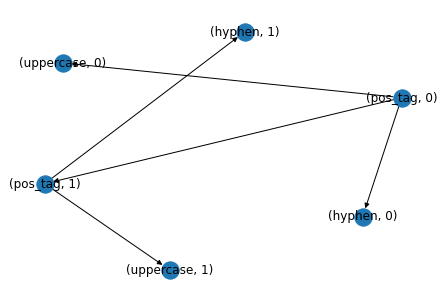

In [7]:
import networkx as nx
import pylab as plt

nx.draw(dbnet, with_labels=True)
plt.show()

In [8]:
from pgmpy.inference import DBNInference

dbn_inf = DBNInference(dbnet)

In [ ]:

def analyce_sentence(sentence, verbose=False):

  words, pos = [word for word,_ in sentence], [pos for _,pos in sentence]

  results = []

  sentence_pos_iter = iter(enumerate(zip(words,pos)))
  position, (prev_word, prev_pos) = next(sentence_pos_iter)

  prev_hyphen = '-' in prev_word
  prev_uppercase = prev_word[0].isupper()
  result = dbn_inf.query([('pos_tag',0)], { # P(POS_0 | *ObservableFeatures)
    (name, 0): value for name, value in  get_features(prev_word).items()
  })[('pos_tag',0)]

  pos_no_to_name = result.no_to_name[("pos_tag",0)]

  max_index, val = max(enumerate(result.values), key= lambda x: x[1])
  predicted_pos = pos_no_to_name[max_index]

  results.append((prev_word, prev_pos, predicted_pos))
  if verbose: print(results[-1])

  for position, (word, pos) in sentence_pos_iter:
    hyphen = '-' in word
    uppercase = word[0].isupper()
    
    result = dbn_inf.query([('pos_tag',1)], { # P(POS_1 | POS_0, *ObservableFeatures)
        ("pos_tag", 0): prev_pos,
        **{(name, 1): value for name, value in get_features(word).items()}
    })[("pos_tag", 1)]

    max_index, val = max(enumerate(result.values), key= lambda x: x[1])

    predicted_pos = pos_no_to_name[max_index]

    results.append((word, pos, predicted_pos))
    if verbose: print(results[-1])
    prev_pos = pos

  positive = 0

  for word, true_pos, pred_pos in results:
    if true_pos == pred_pos:
      positive += 1

  return positive, len(results)

def analyce_sentences(sentences):
  total = 0
  positive = 0
  for sentence in sentences:
    new_positive, new_total = analyce_sentence(sentence)
    positive += new_positive
    total += new_total
  print("Positive", positive)
  print("Total", total)
  print("Precision", positive/total)
  return positive, total

# print("Train Acc")
# train_positive, train_total = analyce_sentences(working_sentences)

print("Test Acc")
test_positive, test_total = analyce_sentences(test_sentences[:5])


In [12]:
print("Results")
print("Test positive", test_positive)
print("Test total", test_total)
print("Test precision", test_positive/test_total)

Results
Test positive 30
Test total 80
Test precision 0.375
